In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [4]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [6]:
root = '/content/drive/MyDrive/DLS 8.1/'
df = pd.read_csv(root+'train.csv')

In [7]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [8]:
#посмотрим несколько случайных строчек
df.sample(n=3)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
518,1,80.00,80,Male,0,Yes,Yes,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Electronic check,1
3744,6,45.65,323.45,Female,0,Yes,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,0
3508,72,110.90,8240.85,Male,0,Yes,No,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0


In [9]:
#есть ли в данных пропуски? сколько их?
df.isna().count()
df.info()
#на первый взгляд, пропусков нет! Но почему в TotalSpent тип -- object, если он 
#числовой?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [10]:
def isnumber(row):

  count = 0
  for item in row:
    item = str(item)
    item = item.replace('.', '') #удаляем точку из десятичных дробей, если нужно
    if not item.isdigit():
      print('gotcha! '+item)
      count += 1
    
  return count
    

In [11]:
isnumber(df['TotalSpent'])
#в данные затесались пробельные символы

gotcha!  
gotcha!  
gotcha!  
gotcha!  
gotcha!  
gotcha!  
gotcha!  
gotcha!  
gotcha!  


9

In [12]:
#проверим, есть ли они где-то еще:
np.where(df.applymap(lambda x: x == ' '))
#больше нигде, кроме как в TotalSpent, нет

(array([1048, 1707, 2543, 3078, 3697, 4002, 4326, 4551, 4598]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [13]:
#удалим пробелы:
df = df.replace(' ', '0')
#проверим
np.where(df.applymap(lambda x: x == ' '))

(array([], dtype=int64), array([], dtype=int64))

In [14]:
#приведем данные к числовому типу
df['TotalSpent'] = df['TotalSpent'].astype('float64')

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

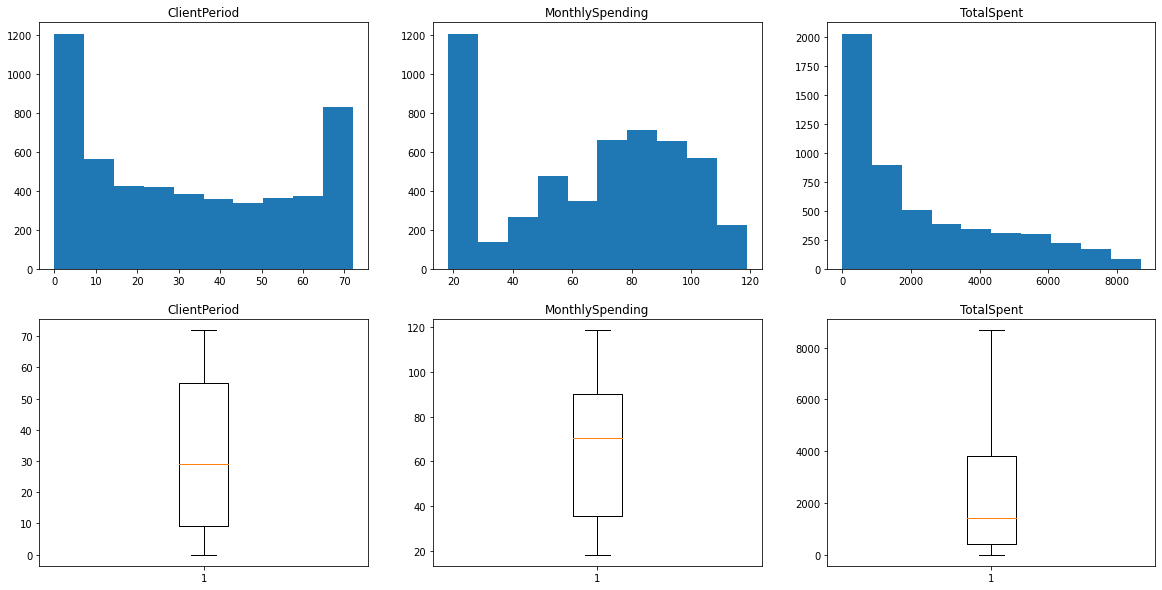

In [15]:
#построим гистограммы и боксплоты:

fig, ax = plt.subplots(2, 3, figsize=(20,10))
for ix, axis in enumerate(ax.flat):
    if ix <= 2:
      axis.set_title(num_cols[ix])
      axis.hist(df[num_cols[ix]])
    else:
      axis.set_title(num_cols[ix - 3])
      axis.boxplot(df[num_cols[ix - 3]])
plt.show()

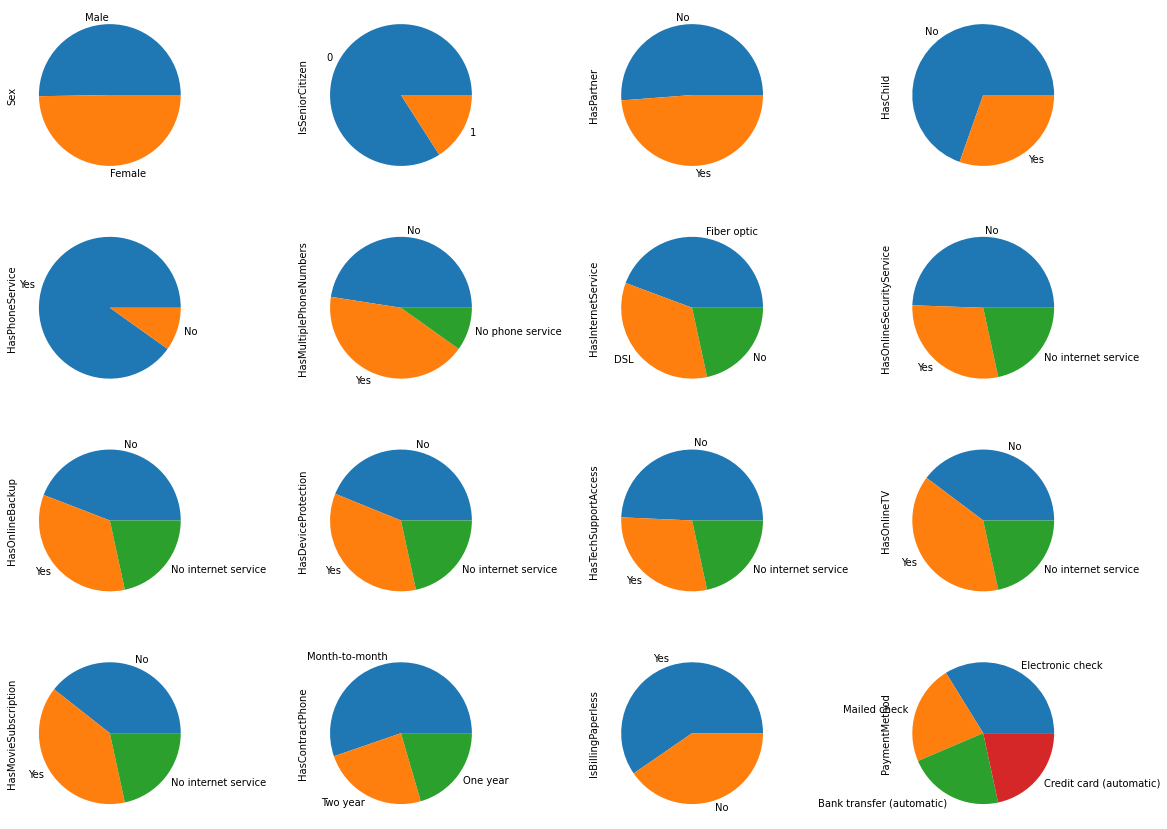

In [16]:
#построим круговые диаграммы для категориальных фич

import math

N = len(cat_cols)

n = math.ceil(math.sqrt(N))

fig, ax = plt.subplots(n, n, figsize=(20,15))
for ix, axis in enumerate(ax.flat):
  df[cat_cols[ix]].value_counts().plot(kind='pie', ax=axis)
plt.show()

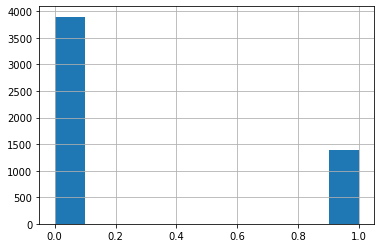

In [17]:
#поглядим на распределение целевой величины
df['Churn'].hist()
#классы несбалансированы

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [18]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [19]:
#создадим валидационные и тестовые выборки
X_train, X_test, Y_train, Y_test = train_test_split(df[num_cols+cat_cols],
                                                    df[target_col], 
                                                    test_size=0.2, random_state=42)

In [20]:
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

In [21]:
#отнормируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

In [22]:
#закодируем с помощью one-hot метода
X_train_encoded = pd.get_dummies(X_train[cat_cols])
X_test_encoded = pd.get_dummies(X_test[cat_cols])

In [23]:
X_train = np.concatenate((X_train_scaled, X_train_encoded.to_numpy()), axis=1)

X_test = np.concatenate((X_test_scaled, X_test_encoded.to_numpy()), axis=1)

In [24]:
cs = [i for i in range(1,10,1)] #список коэффициентов регуляризации

In [25]:
model = LogisticRegressionCV(Cs=cs, cv=7, random_state=42, refit=True,
                             scoring = 'roc_auc', max_iter=1000)
model.fit(X_train, Y_train)


LogisticRegressionCV(Cs=[1, 2, 3, 4, 5, 6, 7, 8, 9], cv=7, max_iter=1000,
                     random_state=42, scoring='roc_auc')

In [26]:
print(model.C_)

[5]


In [27]:
train_score = model.score(X_train, Y_train)
train_score

0.853655945273877

In [28]:
test_score = model.score(X_test, Y_test)
test_score

0.828063095095169

Выпишите какое лучшее качество и с какими параметрами вам удалось получить  
**best_rocauc = 0.828063095095169\
C = 5**

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [ ]:
#создадим необработанные выборки для catboost
X_train, X_test, Y_train, Y_test = train_test_split(df[num_cols+cat_cols],
                                                    df[target_col], 
                                                    test_size=0.2, random_state=42)

In [ ]:
!pip install catboost

In [ ]:
import catboost

In [ ]:
#найдем индексы категориальных колонок
cat_indices = [i for i, item in enumerate(df.columns) if item in cat_cols]
#num_indices = [i for i, item in enumerate(df.columns) if item in num_cols]

In [ ]:
boosting_model = catboost.CatBoostClassifier(eval_metric='AUC',random_seed = 42,
                                             cat_features=cat_indices)
boosting_model.fit(X_train, Y_train)

Learning rate set to 0.019062
0:	total: 76.2ms	remaining: 1m 16s
1:	total: 89.7ms	remaining: 44.7s
2:	total: 106ms	remaining: 35.2s
3:	total: 119ms	remaining: 29.7s
4:	total: 131ms	remaining: 26.1s
5:	total: 142ms	remaining: 23.5s
6:	total: 153ms	remaining: 21.8s
7:	total: 160ms	remaining: 19.8s
8:	total: 168ms	remaining: 18.5s
9:	total: 179ms	remaining: 17.7s
10:	total: 192ms	remaining: 17.3s
11:	total: 196ms	remaining: 16.1s
12:	total: 210ms	remaining: 16s
13:	total: 217ms	remaining: 15.2s
14:	total: 225ms	remaining: 14.8s
15:	total: 238ms	remaining: 14.6s
16:	total: 246ms	remaining: 14.2s
17:	total: 259ms	remaining: 14.1s
18:	total: 267ms	remaining: 13.8s
19:	total: 280ms	remaining: 13.7s
20:	total: 291ms	remaining: 13.6s
21:	total: 303ms	remaining: 13.5s
22:	total: 314ms	remaining: 13.3s
23:	total: 321ms	remaining: 13.1s
24:	total: 334ms	remaining: 13s
25:	total: 347ms	remaining: 13s
26:	total: 356ms	remaining: 12.8s
27:	total: 368ms	remaining: 12.8s
28:	total: 380ms	remaining: 12.

In [ ]:
#найдем лучший скор:
train_score = boosting_model.score(X_train, Y_train)
train_score

0.840473372781065

In [ ]:
test_score = boosting_model.score(X_test, Y_test)
test_score

0.7795648060548723

Теперь попробуем найти оптимальные параметры:

In [ ]:
LRs = (0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.001)

In [ ]:
grid = {'learning_rate': [0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.001],
        'n_estimators' : np.linspace(100, 1000, 10)}

In [ ]:
bassboosting_model = catboost.CatBoostClassifier(silent=True,
                                             cat_features=cat_indices,
                                             eval_metric='AUC:hints=skip_train~false',
                                             random_seed = 42,
                                             metric_period=1000)
params = bassboosting_model.grid_search(grid, X_train,
                               Y_train, cv=3, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8381570623
bestIteration = 99

0:	loss: 0.8381571	best: 0.8381571 (0)	total: 770ms	remaining: 53.1s

bestTest = 0.8377365137
bestIteration = 99

1:	loss: 0.8377365	best: 0.8381571 (0)	total: 1.39s	remaining: 47.3s

bestTest = 0.8350946055
bestIteration = 99

2:	loss: 0.8350946	best: 0.8381571 (0)	total: 1.95s	remaining: 43.6s

bestTest = 0.831985421
bestIteration = 99

3:	loss: 0.8319854	best: 0.8381571 (0)	total: 2.65s	remaining: 43.7s

bestTest = 0.8299114332
bestIteration = 99

4:	loss: 0.8299114	best: 0.8381571 (0)	total: 3.44s	remaining: 44.7s

bestTest = 0.8191101622
bestIteration = 99

5:	loss: 0.8191102	best: 0.8381571 (0)	total: 4.15s	remaining: 44.3s

bestTest = 0.788730015
bestIteration = 99

6:	loss: 0.7887300	best: 0.8381571 (0)	total: 4.79s	remaining: 43.1s

bestTest = 0.8326432022
bestIteration = 199

7:	loss: 0.8326432	best: 0.8381571 (0)	total: 7.14s	remaining: 55.4s

bestTest = 0.8344440131
bestIteration = 199

8:	loss: 0.8344440	best: 0.8381571 (0)	tota

In [ ]:
bassboosting_model.score(X_test, Y_test)

0.7795648060548723

In [ ]:
bassboosting_model.get_params()

{'random_seed': 42,
 'silent': True,
 'metric_period': 1000,
 'eval_metric': 'AUC:hints=skip_train~false',
 'cat_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 'learning_rate': 0.02,
 'iterations': 600.0}

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Что-то бустинг подкачал! Будем использовать линейную регрессию.

# Предсказания

In [29]:
best_model = model

In [30]:
#обработаем также тестовый датасет:
tstdf = pd.read_csv(root+'test.csv')
#удалим пробелы:
tstdf = tstdf.replace(' ', '0')
#проверим
np.where(tstdf.applymap(lambda x: x == ' '))
#приведем данные к числовому типу
tstdf['TotalSpent'] = tstdf['TotalSpent'].astype('float64')

In [31]:
tstdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [32]:
tstdf_scaled = scaler.fit_transform(tstdf[num_cols])
tstdf_encoded = pd.get_dummies(tstdf[cat_cols])
Final_test = np.concatenate((tstdf_scaled, tstdf_encoded.to_numpy()), 
                            axis=1)


In [33]:
submission = pd.read_csv(root+'submission.csv')


In [34]:
submission.shape

(1761, 2)

In [35]:
Final_test.shape

(1761, 45)

In [36]:
best_model.predict_proba(Final_test)

array([[0.96144148, 0.03855852],
       [0.26808805, 0.73191195],
       [0.32014532, 0.67985468],
       ...,
       [0.25574276, 0.74425724],
       [0.3387134 , 0.6612866 ],
       [0.99184063, 0.00815937]])

In [37]:
predictions = best_model.predict_proba(Final_test)

In [38]:
predictions[:, 1]

array([0.03855852, 0.73191195, 0.67985468, ..., 0.74425724, 0.6612866 ,
       0.00815937])

In [41]:
submission['Churn'] = predictions[:, 1]
submission.to_csv(root+'my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.